# 🙌🏾 Murakaza Neza !
### Welcome to this tutorial for the 2025 Kinyarwanda Automatic Speech Recognition Track A Challenge !

Competition page: https://www.kaggle.com/competitions/kinyarwanda-automatic-speech-recognition-track-a

This is a simple tutorial for leveraging the preprocessed dataset [kinasr2025-track-a-melspec](https://www.kaggle.com/datasets/cedricmanouan11/kinasr2025-track-a-melspec) that shares extracted mel spectrograms to build  ASR models for the `Kinyarwanda Automatic Speech Recognition Track A Challenge`.
You can check the `spec_params` variables below to see the parameters used to generate the log mel spectrograms. 

Key featurers:
* ✅ Dataset class
* ✅ Data module class (for later integration with [(Pytorch) Lightning](https://lightning.ai/docs/pytorch/stable/starter/introduction.html))
* ✅ Simple character-based tokenizer
* ✅ Data visualization + EDA utility functions
* ✅ An example config class 

In [1]:
! python -m pip install lightning -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible

# 📚 Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import os
import os.path as osp

import pandas as pd
from pathlib import Path

import lightning
import lightning.pytorch as pl

import seaborn as sns
import sys
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(f"{torch.__version__=}")
print(f"{torchaudio.__version__=}")
print(f"{lightning.__version__=}")
print(f"{np.__version__=}")
print(f"{pd.__version__=}")


torch.__version__='2.6.0+cu124'
torchaudio.__version__='2.6.0+cu124'
lightning.__version__='2.5.1.post0'
np.__version__='1.26.4'
pd.__version__='2.2.3'


# ⚙️ Config

In [4]:
config_dict = {
    "paths":{
        "data_path": "/kaggle/input/kinasr2025-track-a-melspec/track_A_audio",
        "preprocessed_path": "/kaggle/input/kinasr2025-track-a-melspec/preprocessed_track_a/preprocessed",
        "features_path": "/kaggle/input/kinasr2025-track-a-melspec/preprocessed_track_a/preprocessed/features"
    },
    "data_pct": 15.,
    "seed": 123,
    "spec_params": {
        "feature_type": "melspec",  # "melspec", "mfcc", or "fbank"
        "sr": 16000,
        "n_feats": 128,
        "specaug_rate": 0.3,
        "time_mask": 30,
        "freq_mask": 5,
        "win_length": 512,
        "n_fft": 2048,
        "n_mels": 128,
        "n_mfcc": 40,
        "f_min": 50.0,
        "f_max": 15000,
        "top_db": 80,
        "power": 2.0    
    },
    "min_len": 10,
    "max_len": 256,
    "max_trim_audio": 30,
    "num_workers": os.cpu_count(),
    "training": {
        "batch_size": 8
    }

}

class DotDict:
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(v, dict):
                v = DotDict(v)
            setattr(self, k, v)

    def __getitem__(self, key):
        return getattr(self, key)

class Config:
    def __init__(self, d:dict=config_dict):
        self.config_dict = d
        self.__dict__.update(DotDict(self.config_dict).__dict__)


cfg = Config()
cfg.spec_params.sr, cfg.spec_params.feature_type, cfg.paths.preprocessed_path

(16000,
 'melspec',
 '/kaggle/input/kinasr2025-track-a-melspec/preprocessed_track_a/preprocessed')

# 🏷️ Tokenizer

We keep it simple and use a character-based tokenizer that handles both `encoding` and `decoding` of the audio transcripts.

In [5]:
class CharTokenizer:
    def __init__(self, vocab_path:str="vocab.json"):
        try:
            with open(vocab_path, "r", encoding="utf-8") as f:
                self.vocab = json.load(f)
            self.char2idx = self.vocab["char2idx"]
            self.idx2char = {int(k): v for k, v in self.vocab["idx2char"].items()}
        except Exception as e:
            base_chars = list(string.ascii_lowercase + string.digits + string.punctuation + " ")
            # Special tokens
            special_tokens = ["<|pad|>", "<|sos|>", "<|eos|>", "<|unk|>"]
            self.vocab = special_tokens + base_chars
            
            # Build mappings
            self.char2idx = {char: idx for idx, char in enumerate(self.vocab)}
            self.idx2char = {int(idx): char for char, idx in self.char2idx.items()}
        
        
        self.pad_idx = self.char2idx["<|pad|>"]
        self.sos_idx = self.char2idx["<|sos|>"]
        self.eos_idx = self.char2idx["<|eos|>"]
        self.unk_idx = self.char2idx["<|unk|>"]

    def encode(self, text, max_len=None):
        tokens = [self.char2idx.get(c, self.unk_idx) for c in text.lower()]
        tokens = [self.sos_idx] + tokens + [self.eos_idx]
        if max_len:
            tokens = tokens[:max_len] + [self.pad_idx] * max(0, max_len - len(tokens))
        return tokens

    def encode_batch(self, texts, max_len=None):
        return [self.encode(t, max_len) for t in texts]

    def decode(self, ids, skip_special=True):
        return "".join(
            [self.idx2char.get(i, "") for i in ids
             if not skip_special or i not in {self.pad_idx, self.sos_idx, self.eos_idx, self.unk_idx}]
        )

    def decode_batch(self, batch_ids, skip_special=True):
        return [self.decode(ids, skip_special) for ids in batch_ids]

    def vocab_size(self):
        return len(self.char2idx)

In [6]:
tokenizer = CharTokenizer()
tokenizer.vocab[:10]

['<|pad|>', '<|sos|>', '<|eos|>', '<|unk|>', 'a', 'b', 'c', 'd', 'e', 'f']

# 🗂️ Load data files

These dataframes were generated based on the original `.json` files provided by the organizers.
We are only using this data format by choice and for easy manipulation.

`tokens` here refer to atomic symbols extracted from sentence with `space` as separator. 

In [7]:
train  = pd.read_csv(osp.join(cfg.paths.preprocessed_path, "train.csv"))
dev    = pd.read_csv(osp.join(cfg.paths.preprocessed_path, "dev_test.csv"))
test   = pd.read_csv(osp.join(cfg.paths.preprocessed_path, "test.csv"))

train.shape, dev.shape, test.shape

((90163, 16), (4632, 16), (4634, 14))

In [8]:
train.head(n=2)

,id,voice_creator_id,image_path,image_category,image_sub_category,audio_path,transcription,age_group,gender,project_name,locale,year,duration,location,sentence_length,num_tokens
0,AYGBpezo9OcAS9jyjVWh,GGV0DaVftpfbL7qn1EbCrqXamdk2,image/PXL_20241204_104642770.MP.jpg,Financial Services,Shopping malls,audio/1738095369-GGV0DaVftpfbL7qn1EbCrqXamdk2,Urenze umuhanda munini n'agahanda k'abanyamagu...,36-49,Female,KINYARWANDA2025,rw_RW,2025,20.40,NaN,173,22
1,K0sLwAQgpkcHQl2F5obe,9Q9RG8PhUva4tKnFqMCjM7796NG3,image/IMG_CD (17).jpg,Financial Services,Car dealerships,audio/1738827604-9Q9RG8PhUva4tKnFqMCjM7796NG3,Ahangaha hari ikinyabiziga cyiza cyane gifite ...,18-24,Female,KINYARWANDA2025,rw_RW,2025,24.84,NaN,310,41


In [9]:
dev.head(n=1)

,id,voice_creator_id,image_path,image_category,image_sub_category,audio_path,transcription,age_group,gender,project_name,locale,year,duration,location,sentence_length,num_tokens
0,BFzbR5Ls9FXwrzMRmcIi,OogTF7X5UsTPNsR9q4GLZYcJiKB2,image/2020-06-05 (1).jpg,Financial Services,Dairy product shops,audio/1739532284-OogTF7X5UsTPNsR9q4GLZYcJiKB2,Akajerekani gateretse hasi ku butaka gapfundik...,18-24,Male,KINYARWANDA2025,rw_RW,2025,16.26,NaN,142,16


In [10]:
test.head(n=2)

,id,voice_creator_id,image_path,image_category,image_sub_category,audio_path,transcription,age_group,gender,project_name,locale,year,duration,location
0,gbs7Mf2cCuKq71qDKmiJ,NQH9ahEaFMau4SYWUphSbr04prt2,image/MTN-Rwanda-norvanreports.jpg,Financial Services,Mobile money kiosks,audio/1739736289-NQH9ahEaFMau4SYWUphSbr04prt2,NaN,25-35,Male,KINYARWANDA2025,rw_RW,2025,17.16,NaN
1,Q02in6O5RFJc9Fyh9zY3,8iuTHK211mZUp2P9r7miF3z2gim2,image/IMG-20241225-WA0008.jpg,Financial Services,Dairy_product_shops,audio/1736929024-8iuTHK211mZUp2P9r7miF3z2gim2,NaN,18-24,Male,KINYARWANDA2025,rw_RW,2025,19.56,NaN


# 🧰 Data utils

## Summary

We are using torchaudio for audio manipulation, so in case `ffmpeg` is not already installed in your environment, please make sure to install it using `apt-get install ffmpeg`.

Note: Failure to do the above may result in difficulties reading the audio files without converting them to other formats e.g. `.wav` `.flac` `.mp3` etc...

## Datasets

Dataset class that can be used for `train`, `dev`, and `test` samples

In [11]:
class SpeechDataset(Dataset):
    def __init__(
            self, 
            subset:str, 
            max_label_len:int=cfg.max_len,
            data_pct:float=0.,
            transform=None
        ):
        self.subset = subset
        self.transform = transform
        self.df = pd.read_csv(osp.join(cfg.paths.preprocessed_path, f"{subset}.csv"))
        if data_pct > 0.:
            self.df = self.df.sample(frac=data_pct / 100.0, random_state=cfg.seed)
        self.tokenizer = CharTokenizer()
        self.max_label_len = max_label_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        item_path = osp.join(cfg.paths.features_path, f"{self.subset}/{self.df.iloc[idx].id}.npz")
        item = np.load(item_path)
        audio_input = torch.tensor(item["mel_spec"], dtype=torch.float32)
        waveform, _ = torchaudio.load(osp.join(cfg.paths.data_path, f"{self.df.iloc[idx].audio_path}"))
        waveform = waveform.squeeze(0).to(torch.float32)

        if self.transform:
            audio_input = self.transform(audio_input)
            
        if self.subset in ["train", "dev_test", "valid"]:
            transcript = self.df.iloc[idx].transcription
            label = item["label"].item() if isinstance(item["label"], np.ndarray) else item["label"]
            tokens = self.tokenizer.encode(label, max_len=self.max_label_len)
        
            return waveform, audio_input, torch.tensor(tokens, dtype=torch.long), transcript
        else:
            return waveform, audio_input

In [12]:
ds = SpeechDataset(subset="dev_test")
waveform, x, tgt, transcript = ds[0]

x.shape, tgt.shape, transcript

(torch.Size([128, 70]),
 torch.Size([256]),
 "Akajerekani gateretse hasi ku butaka gapfundikiye neza, gapfundiki umuvuniko w'umweru n'akajerekani karasa n'umweru, akajerekani karimo amata.")

## Data module

A data module makes it easier to further run experiments using pytorch lightning.

In [13]:
def pad_batch_tensors(
        tensor_list:list, 
        pad_value:int
    ):
    """
    Function to pad a batch of tensors to the same size along the last dimension.

    Args:
        tensor_list (list of torch.Tensor): List of tensors with varying lengths.
        pad_value (int, optional): Value to use for padding. Default is 0.

    Returns:
        torch.Tensor: Padded batch tensor.
    """
    if len(tensor_list) == 0:
        raise ValueError("Input tensor list is empty.")

    max_length = max(tensor.shape[-1] for tensor in tensor_list)
        
    base_shape = list(tensor_list[0].shape[:-1])  # Keeps all dimensions except the last one
    padded_tensors = torch.full([len(tensor_list)] + base_shape + [max_length], pad_value, dtype=torch.float)

    for i, tensor in enumerate(tensor_list):
        padded_tensors[i, ..., :tensor.shape[-1]] = tensor

    return padded_tensors

def collate_fn(batch):
    waveform_batch, input_batch, target_batch, transcripts = zip(*batch)

    # pad tensors
    waveform_batch = pad_batch_tensors(waveform_batch, pad_value=0)
    input_batch = pad_batch_tensors(input_batch, pad_value=0)
    target_batch = pad_batch_tensors(target_batch, pad_value=0)
    
    return waveform_batch, input_batch, target_batch, transcripts

def test_collate_fn(batch):
    waveform_batch, input_batch = zip(*batch)

    # pad tensors
    waveform_batch = pad_batch_tensors(waveform_batch, pad_value=0)
    input_batch = pad_batch_tensors(input_batch, pad_value=0)
    
    return waveform_batch, input_batch

In [14]:
class SpeechDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        train_df:pd.DataFrame, 
        dev_df:pd.DataFrame, 
        batch_size:int=cfg.training.batch_size, 
        num_workers:int=cfg.num_workers, 
        max_label_len:int=cfg.max_len,
        data_pct=cfg.data_pct
    ):
        super().__init__()
        self.train_df = train_df
        self.dev_df = dev_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_label_len = max_label_len
        self.data_pct = data_pct

    def setup(self, stage=None):
        self.train_set = SpeechDataset("train", data_pct=self.data_pct)
        self.dev_set = SpeechDataset("dev_test")
        self.test_set = SpeechDataset("test")
        
        num_val_samples = len(self.dev_set)
        num_train_samples = len(self.train_set)
        num_test_samples = len(self.test_set)
        
        print(f"> # Training samples: {num_train_samples}")
        print(f"> # Validation samples: {num_val_samples}")
        print(f"> # Test samples: {num_test_samples}")
        
    def train_dataloader(self):
        return DataLoader(
            self.train_set, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=self.num_workers, 
            pin_memory=True,
            collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.dev_set, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers, 
            pin_memory=True,
            collate_fn=collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=self.num_workers, 
            pin_memory=True,
            collate_fn=test_collate_fn
        )

# 👨🏾‍🔬 Test Data modules

In [15]:
dm = SpeechDataModule(train_df=train, dev_df=dev)
dm.setup()

> # Training samples: 13524
> # Validation samples: 4632
> # Test samples: 4634


In [16]:
train_waveform_batch, train_batch_inp, train_batch_tgt, batch_transcripts = next(iter(dm.train_dataloader()))

train_waveform_batch.shape, train_batch_inp.shape, train_batch_tgt.shape

(torch.Size([8, 1123200]), torch.Size([8, 128, 100]), torch.Size([8, 256]))

In [17]:
dev_waveform_batch, dev_batch_inp, dev_batch_tgt, dev_batch_transcripts = next(iter(dm.val_dataloader()))

dev_waveform_batch.shape, dev_batch_inp.shape, dev_batch_tgt.shape

(torch.Size([8, 1226880]), torch.Size([8, 128, 110]), torch.Size([8, 256]))

# 🕵🏾 EDA + Data (batch) visualization

In [18]:
def visualize_statistics(df, numeric_cols: list, categorical_cols: list):
    """
    Visualizes numeric data distributions (histograms, box plots, scatter plots) and categorical distributions (bar plots).
    
    Args:
    df (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric columns (e.g., sentence_length, duration).
    categorical_cols (list): List of categorical columns (e.g., gender, recording_lang).
    """

    num_numeric = len(numeric_cols)
    num_categorical = len(categorical_cols)

    fig, axes = plt.subplots(1, num_numeric, figsize=(5 * num_numeric, 6))
    
    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color="blue")
        axes[i].set_title(f"{col} Distribution")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

        # sns.boxplot(y=df[col], ax=axes[1, i], color="red")
        # axes[1, i].set_title(f"{col} Box Plot")

    plt.tight_layout()
    plt.show()

    if num_categorical > 0:
        fig, axes = plt.subplots(1, num_categorical, figsize=(5 * num_categorical, 3))
    
        if num_categorical == 1:
            axes = [axes]  # Ensure axes is iterable for single column

        for i, col in enumerate(categorical_cols):
            top_categories = df[col].value_counts().nlargest(10)
            sns.barplot(x=top_categories.values, y=top_categories.index, ax=axes[i], color="green")
            axes[i].set_title(f"Top {col} Categories")
            axes[i].set_xlabel("Count")
            axes[i].set_ylabel(col)

        plt.tight_layout()
        plt.show()
    

    if len(numeric_cols) > 1:
        fig, axes = plt.subplots(1, len(numeric_cols) - 1, figsize=(5 * (len(numeric_cols) - 1), 5))
        
        if len(numeric_cols) == 2:
            axes = [axes]  # Ensure axes is iterable for only one scatter plot
        
        for i in range(1, len(numeric_cols)):
            sns.scatterplot(x=df[numeric_cols[i - 1]], y=df[numeric_cols[-1]], ax=axes[i - 1], color="purple", alpha=0.5)
            axes[i - 1].set_title(f"{numeric_cols[i-1]} vs. {numeric_cols[-1]}")
            axes[i - 1].set_xlabel(numeric_cols[i-1])
            axes[i - 1].set_ylabel(numeric_cols[-1])

        plt.tight_layout()
        plt.show()

def plot_random_waveforms(
        df, 
        audio_col: str, 
        text_col: str, 
        translation_col:str,
        audio_dir: str, 
        num_files: int = 2
    ):
    """
    Plots waveforms and plays audio from random samples in a DataFrame, displaying their transcriptions.

    Args:
    df (pd.DataFrame): The DataFrame containing audio file names and transcriptions.
    audio_col (str): Column name containing the audio file names.
    text_col (str): Column name containing transcriptions.
    audio_dir (str): Directory where the audio files are stored.
    num_files (int): Number of random files to display.
    """
    # Select random rows
    selected_rows = df.sample(n=min(num_files, len(df)))

    # Determine the number of rows needed for a 2-column layout
    num_cols = 2
    num_rows = math.ceil(len(selected_rows) / num_cols)

    # Create subplots (2-column layout)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, num_rows * 2))
    axes = axes.flatten()  # Flatten in case of single-row subplots

    # Fill extra empty subplots if needed
    for i in range(len(selected_rows), len(axes)):
        fig.delaxes(axes[i])

    audio_players = []
    for ax, (_, row) in zip(axes, selected_rows.iterrows()):
        file_name = row[audio_col]
        transcription = row[text_col]
        if translation_col:
            translation = row[translation_col]
        file_path = os.path.join(audio_dir, file_name)

        # Load audio
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            waveform = waveform.mean(dim=0)  # Convert to mono if stereo

            # Plot waveform
            ax.plot(torch.arange(waveform.shape[0]) / sample_rate, waveform.numpy(), color="blue")
            ax.set_title(f'File: {file_name} ({waveform.shape[0] / sample_rate:.2f} sec)')
            ax.set_xlabel("Time (seconds)")
            ax.set_ylabel("Amplitude")

            # Store audio player and transcription for later display
            audio_players.append((file_name, ipd.Audio(waveform.numpy(), rate=sample_rate), transcription))
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

    plt.tight_layout()
    plt.show()

    # Display audio playback and transcriptions
    for file_name, player, transcription in audio_players:
        print(f"🔊 Playing: {file_name}")
        display(player)
        print(f"📝 Transcription: {transcription}\n")
        if translation_col:
            print(f"📝EN Translation: {translation}\n")
        print()

In [19]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,90163.0,2025.000000,0.000000,2025.00,2025.00,2025.00,2025.00,2025.00
duration,90163.0,19.586734,3.471467,2.04,16.98,18.72,21.42,68.82
sentence_length,90163.0,207.016503,60.321574,15.00,165.00,198.00,239.00,845.00
num_tokens,90163.0,27.775285,8.429682,3.00,22.00,27.00,32.00,108.00


### 📊 Taining stats

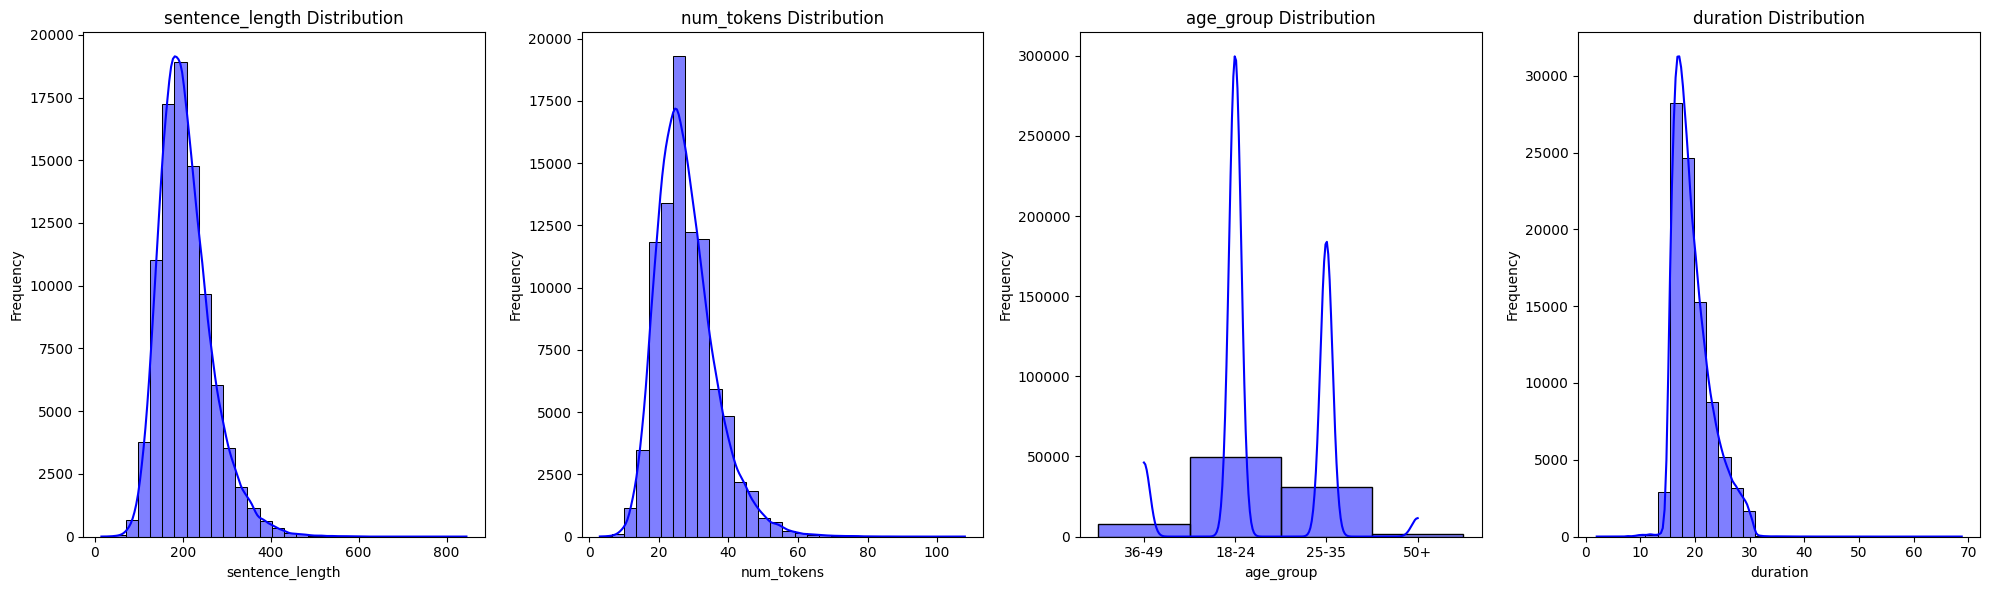

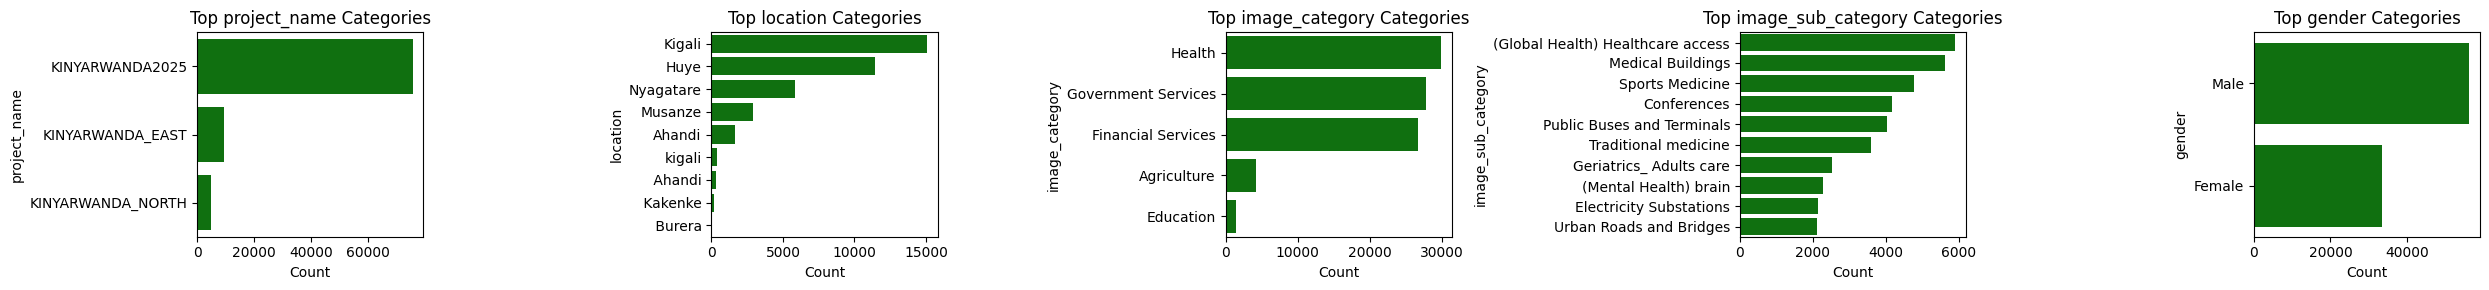

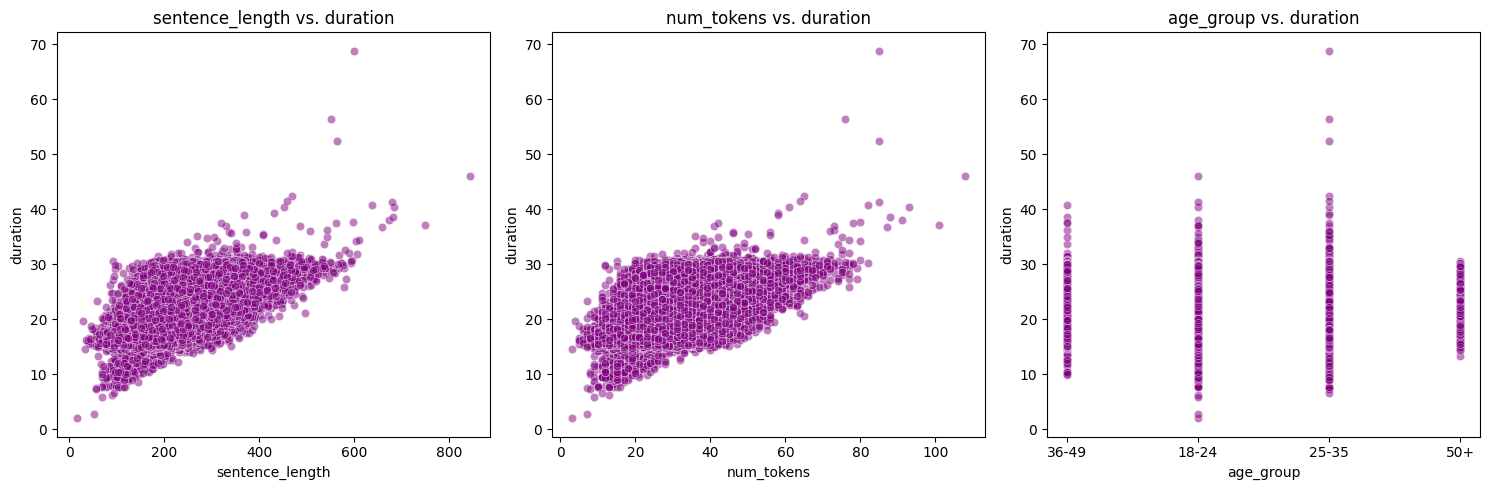

In [20]:
num_cols = ['sentence_length', 'num_tokens', 'age_group', 'duration']
cat_cols = ['project_name', 'location', 'image_category', 'image_sub_category', 'gender']

visualize_statistics(df=train, numeric_cols=num_cols, categorical_cols=cat_cols)

### 📊 Validation Stats

In [21]:
dev.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,4632.0,2025.000000,0.000000,2025.00,2025.00,2025.00,2025.00,2025.0
duration,4632.0,19.520031,3.433419,8.22,16.98,18.66,21.36,41.1
sentence_length,4632.0,205.629965,59.510687,57.00,165.00,196.00,238.00,543.0
num_tokens,4632.0,27.544257,8.301994,6.00,22.00,26.00,32.00,73.0


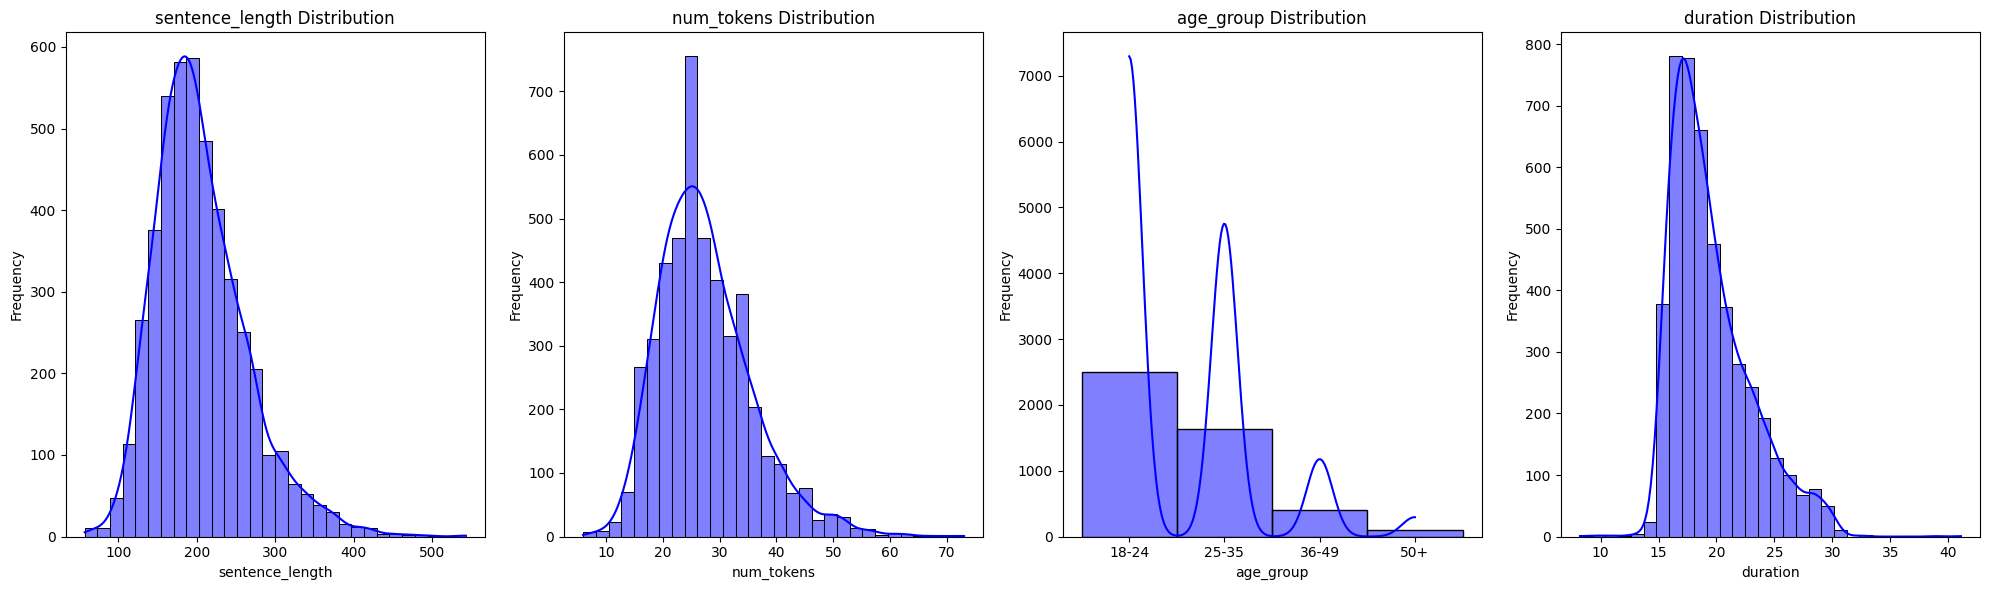

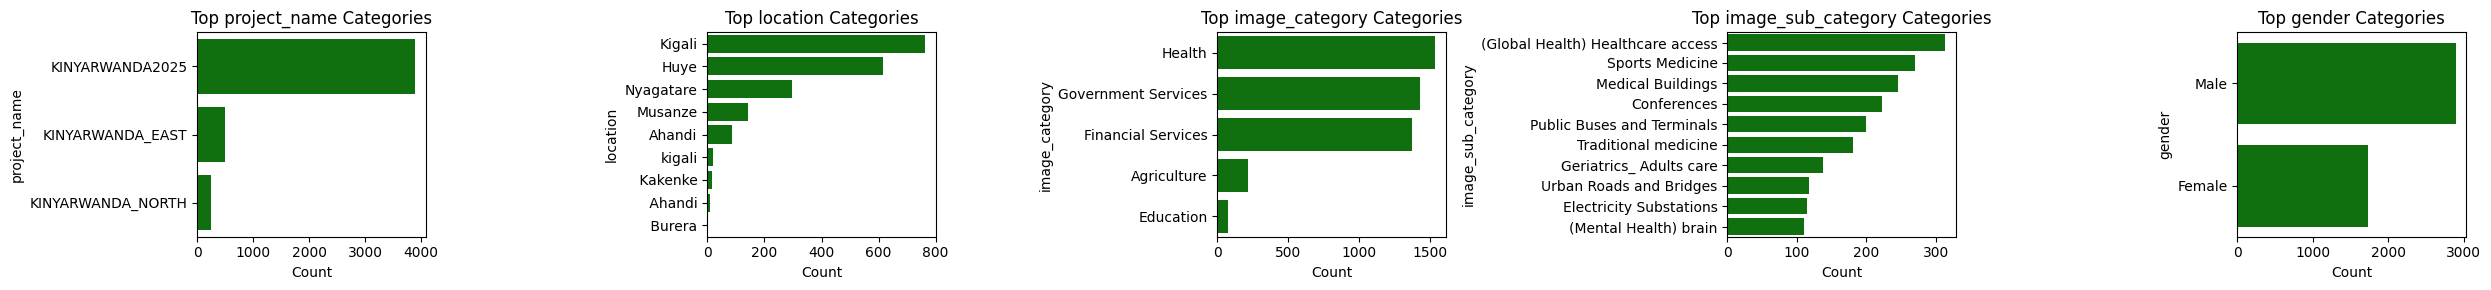

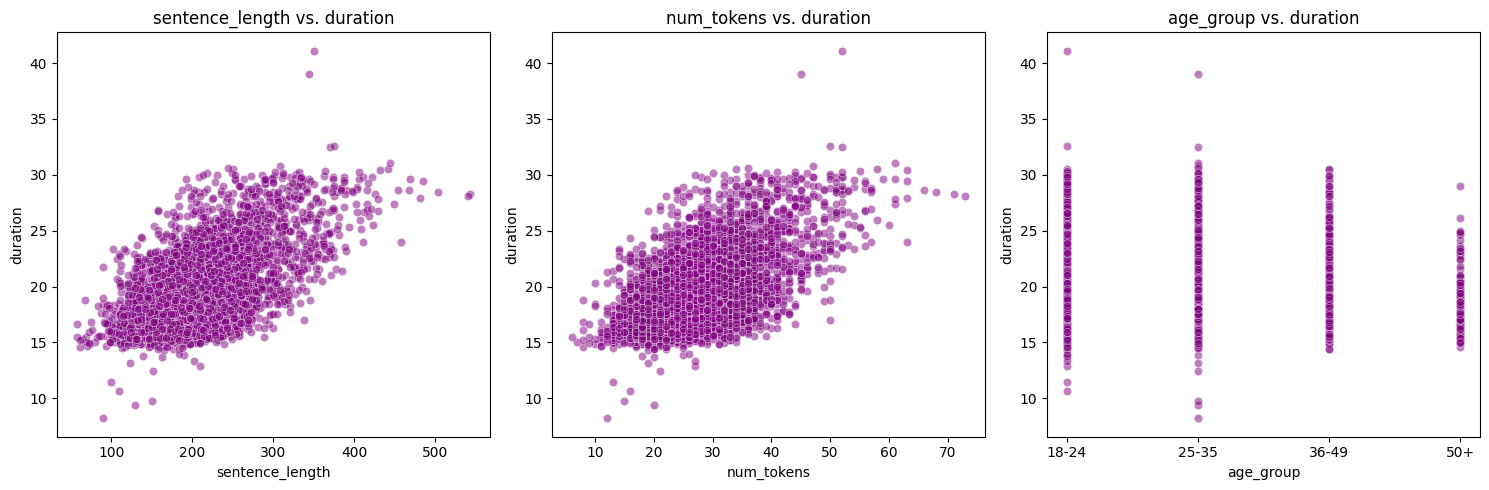

In [22]:
visualize_statistics(df=dev, numeric_cols=num_cols, categorical_cols=cat_cols)

### 📊 Test Stats

In [23]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transcription,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,4634.0,2025.000000,0.000000,2025.00,2025.00,2025.00,2025.00,2025.00
duration,4634.0,19.573894,3.436693,6.84,16.98,18.72,21.42,34.92


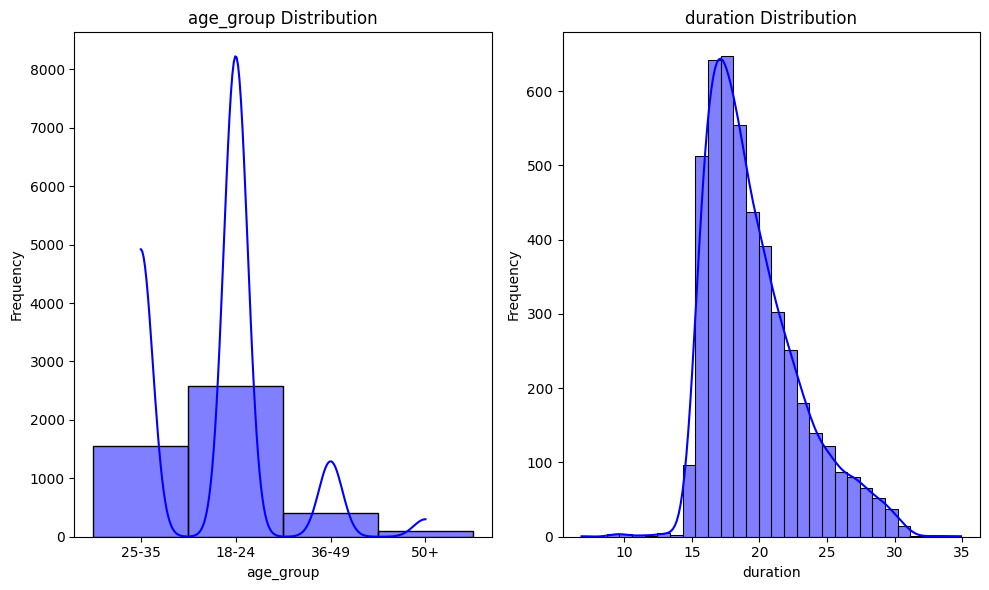

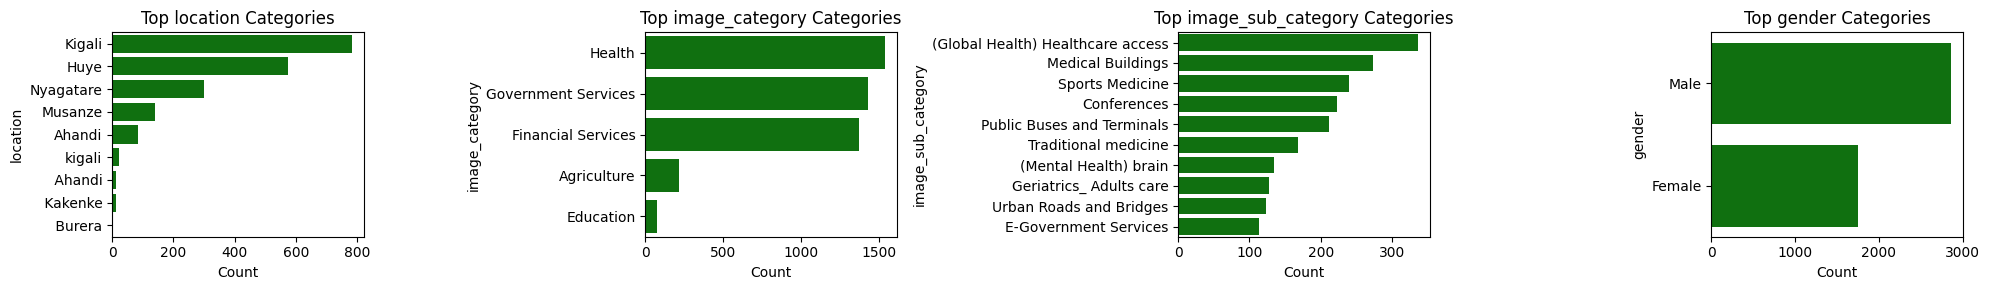

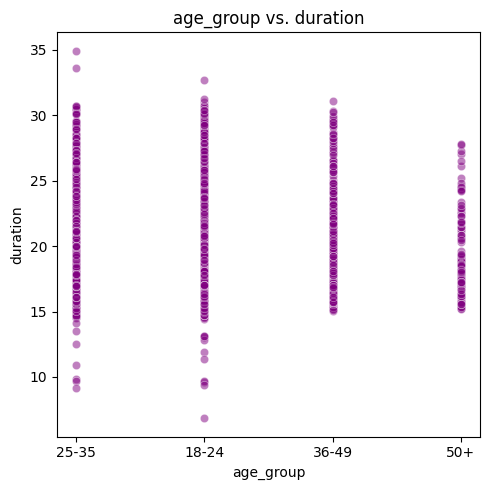

In [24]:
num_cols = ['age_group', 'duration']
cat_cols = ['location', 'image_category', 'image_sub_category', 'gender']

visualize_statistics(df=test, numeric_cols=num_cols, categorical_cols=cat_cols)

In [25]:
num_short_audios = train[train["duration"] <10].shape[0]
num_avg_audios = train[(train["duration"] >=10) & (train["duration"] <=30)].shape[0]
num_long_audios = train[train["duration"] >30].shape[0]

pct_short = 100*num_short_audios / train.shape[0]
pct_avg = 100*num_avg_audios / train.shape[0]
pct_long = 100*num_long_audios / train.shape[0]

print(f"# short audio samples: \t{num_short_audios} ({pct_short:.2f}%)")
print(f"# avg audio samples: \t{num_avg_audios} ({pct_avg:.2f}%)")
print(f"# long audio samples: \t{num_long_audios} ({pct_long:.2f}%)")

# short audio samples: 	61 (0.07%)
# avg audio samples: 	89558 (99.33%)
# long audio samples: 	544 (0.60%)


In [26]:
num_short_audios = dev[dev["duration"] <10].shape[0]
num_avg_audios = dev[(dev["duration"] >=10) & (dev["duration"] <=30)].shape[0]
num_long_audios = dev[dev["duration"] >30].shape[0]

pct_short = 100*num_short_audios / dev.shape[0]
pct_avg = 100*num_avg_audios / dev.shape[0]
pct_long = 100*num_long_audios / dev.shape[0]

print(f"# short audio samples: \t{num_short_audios} ({pct_short:.2f}%)")
print(f"# avg audio samples: \t{num_avg_audios} ({pct_avg:.2f}%)")
print(f"# long audio samples: \t{num_long_audios} ({pct_long:.2f}%)")

# short audio samples: 	3 (0.06%)
# avg audio samples: 	4611 (99.55%)
# long audio samples: 	18 (0.39%)


In [27]:
num_short_audios = test[test["duration"] <10].shape[0]
num_avg_audios = test[(test["duration"] >=10) & (test["duration"] <=30)].shape[0]
num_long_audios = test[test["duration"] >30].shape[0]

pct_short = 100*num_short_audios / test.shape[0]
pct_avg = 100*num_avg_audios / test.shape[0]
pct_long = 100*num_long_audios / test.shape[0]

print(f"# short audio samples: \t{num_short_audios} ({pct_short:.2f}%)")
print(f"# avg audio samples: \t{num_avg_audios} ({pct_avg:.2f}%)")
print(f"# long audio samples: \t{num_long_audios} ({pct_long:.2f}%)")

# short audio samples: 	7 (0.15%)
# avg audio samples: 	4598 (99.22%)
# long audio samples: 	29 (0.63%)


By focusing on audio samples with durations between `10s` and `30s`, we retain more than `99%` of the original datasets; this is quite enough for initial experiments or even the entire challenge.

### 🗄️ Batch inspection

In [28]:
def visualize_batch(
    data_module, 
    n_samples=cfg.training.batch_size, 
    loader:str="train"
   ):
    """
    Visualizes a batch of speech data: spectrograms and corresponding transcripts.

    Args:
        data_module (SpeechDataModule): The data module for loading batches.
        n_samples (int): Number of samples to visualize.
        loader (str) : One of "train", "test", or "dev"
    """
    # Load the data
    dataloaders = {
        "train": data_module.train_dataloader(),
        "dev": data_module.val_dataloader(),
        "test": data_module.test_dataloader()
    }
    assert loader in ["train", "test", "dev"], "visualization `loader` only supports 'train', 'test', or 'dev' as values."
    dl = dataloaders[loader]
    wavforms, inputs, targets, transcripts = next(iter(dl))

    # Extract data
    wavforms = wavforms[:n_samples] 
    inputs = inputs[:n_samples] 
    targets = targets[:n_samples] 
    transcripts = transcripts[:n_samples]

    # Plot data
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 2), constrained_layout=True)

    for i in range(n_samples):
        inp = axes[i, 0].imshow(inputs[i].numpy(), aspect="auto", origin="lower", cmap="magma")
        axes[i, 0].set_title(f"Transcript - {transcripts[i][:64]}...", fontsize=8)
        axes[i, 0].set_xlabel("Time")
        axes[i, 0].set_ylabel("Frequency")
        fig.colorbar(inp, ax=axes[i, 0], orientation="vertical", fraction=0.05, pad=0.05)
        
        wav = wavforms[i]
        axes[i, 1].plot(torch.arange(wav.shape[0]) / cfg.spec_params.sr, wav.numpy(), color="blue")
        axes[i, 1].set_title(f"Transcript - {transcripts[i][:64]}...", fontsize=8)
        axes[i, 1].set_xlabel("Time (seconds)")
        axes[i, 1].set_ylabel("Amplitude")
        
    # plt.tight_layout()
    plt.show()

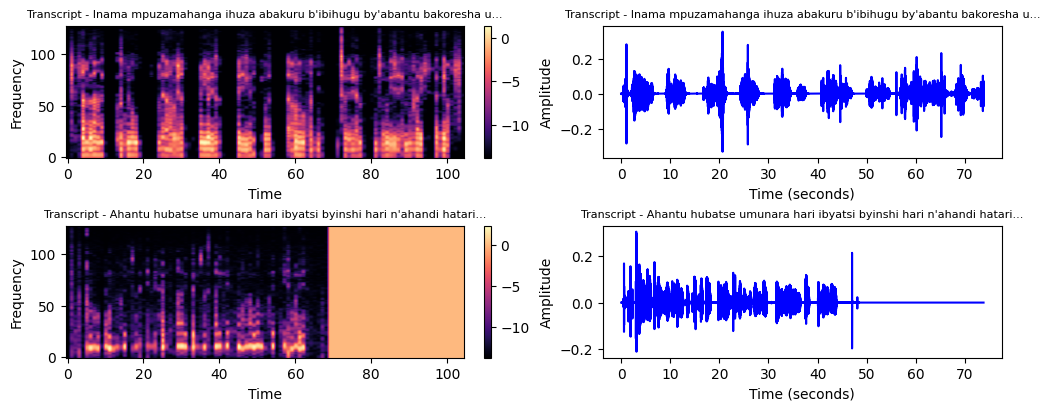

CPU times: user 52.9 s, sys: 2.47 s, total: 55.3 s
Wall time: 57.4 s


In [29]:
%%time
visualize_batch(data_module=dm, n_samples=2, loader="train")

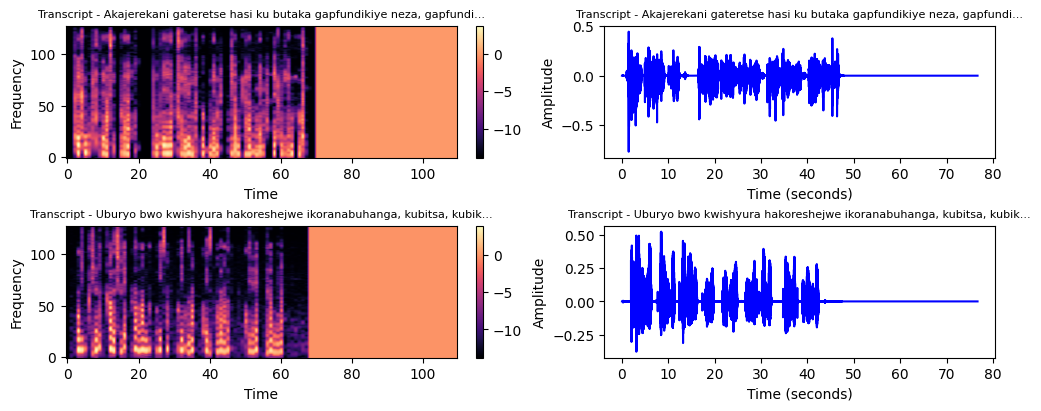

CPU times: user 55 s, sys: 1.92 s, total: 56.9 s
Wall time: 58.5 s


In [30]:
%%time
visualize_batch(data_module=dm, n_samples=2, loader="dev")

Note: The visualization seems to take a bit longer in kaggle kernels. You should be aware of how this might affect your data loading pipeline.

In [31]:
test_ds = SpeechDataset(subset="test")
test_wav, test_inp = test_ds[0]

test_wav.shape, test_inp.shape

(torch.Size([823680]), torch.Size([128, 74]))

In [32]:
test_batch_wav, test_batch_inp = next(iter(dm.test_dataloader()))
test_batch_wav.shape, test_batch_inp.shape

(torch.Size([8, 1227776]), torch.Size([8, 128, 110]))

# 🏁 Conclusion

You have reached the end of this tutorial.

🤗 In addition to being an interesting competition, this challenge is a great way to demonstrate our local expertise in adressing our own gaps and try to bridge the current digital divide. 

If you enjoyed this notebook, please give it an upvote and leave a comment so that other people can find it too! 🥺

🎉 Best of luck Kaggling...Murakoze Cyaaaane!